# Combining Smartphone Health Metrics with Open Weather Data
The following will focus on exported steps data from an Apple iPhone and local weather data to merge data sets and make predictions using a linear regression model.

In [1]:
# Import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Read in health data
data = pd.read_xml('apple_health_export/export.xml')
data.dtypes

value                                                         object
HKCharacteristicTypeIdentifierDateOfBirth                     object
HKCharacteristicTypeIdentifierBiologicalSex                   object
HKCharacteristicTypeIdentifierBloodType                       object
HKCharacteristicTypeIdentifierFitzpatrickSkinType             object
HKCharacteristicTypeIdentifierCardioFitnessMedicationsUse     object
type                                                          object
sourceName                                                    object
sourceVersion                                                 object
unit                                                          object
creationDate                                                  object
startDate                                                     object
endDate                                                       object
device                                                        object
MetadataEntry                     

In [3]:
# Read in weather data export
# Pulled 2023 (Jan-Sept) weather station data for USW00014771 for SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US from NOAA
weather = pd.read_csv('syr_weather.csv')
weather.dtypes

STATION       object
NAME          object
LATITUDE     float64
LONGITUDE    float64
ELEVATION    float64
DATE          object
AWND         float64
DAPR         float64
MDPR         float64
PGTM         float64
PRCP         float64
SNOW         float64
SNWD         float64
TAVG           int64
TMAX         float64
TMIN         float64
TOBS         float64
WDF2         float64
WDF5         float64
WESD         float64
WESF         float64
WSF2         float64
WSF5         float64
WT01         float64
WT02         float64
WT03         float64
WT04         float64
WT05         float64
WT06         float64
WT08         float64
WT09         float64
dtype: object

In [4]:
# There are different qualifiers depending on the type column, all of which might have associated data in the value column
data['type'].unique()

array([None, 'HKQuantityTypeIdentifierHeight',
       'HKQuantityTypeIdentifierBodyMass',
       'HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierRestingHeartRate',
       'HKQuantityTypeIdentifierWalkingHeartRateAverage',
       'HKQuantityTypeIdentifierHeadphoneAudioExposure',
       'HKQuantityTypeIdentifierAppleStandTime',
       'HKCategoryTypeIdentifierAppleStandHour',
       'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'], dtype=object)

In [5]:
# Convert the dates to datetime format for both data sets
data['startDate'] = pd.to_datetime(data['startDate'])
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [6]:
# Filter the data to only include steps
steps = data[data['type'] == 'HKQuantityTypeIdentifierStepCount']
steps = steps[['startDate', 'value']]
steps.head()

,startDate,value
150,2020-06-17 21:24:38-04:00,17
151,2020-06-14 16:24:47-04:00,18
152,2020-06-14 18:00:19-04:00,68
153,2020-06-14 18:27:09-04:00,117
154,2020-06-14 21:09:22-04:00,33


In [7]:
steps['Date'] = steps['startDate'].dt.strftime('%m/%d/%Y')

In [8]:
steps.head()

,startDate,value,Date
150,2020-06-17 21:24:38-04:00,17,06/17/2020
151,2020-06-14 16:24:47-04:00,18,06/14/2020
152,2020-06-14 18:00:19-04:00,68,06/14/2020
153,2020-06-14 18:27:09-04:00,117,06/14/2020
154,2020-06-14 21:09:22-04:00,33,06/14/2020


In [9]:
steps['Date'] = pd.to_datetime(steps['Date'])

In [10]:
steps.dtypes

startDate    datetime64[ns, pytz.FixedOffset(-240)]
value                                        object
Date                                 datetime64[ns]
dtype: object

In [11]:
steps.head()

,startDate,value,Date
150,2020-06-17 21:24:38-04:00,17,2020-06-17
151,2020-06-14 16:24:47-04:00,18,2020-06-14
152,2020-06-14 18:00:19-04:00,68,2020-06-14
153,2020-06-14 18:27:09-04:00,117,2020-06-14
154,2020-06-14 21:09:22-04:00,33,2020-06-14


In [12]:
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,DAPR,MDPR,PGTM,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-01,8.28,NaN,NaN,NaN,...,23.0,29.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-02,4.92,NaN,NaN,NaN,...,12.1,14.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-03,5.14,NaN,NaN,NaN,...,13.0,16.1,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-04,5.14,NaN,NaN,NaN,...,15.0,19.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-05,5.37,NaN,NaN,NaN,...,19.9,23.9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Filter the steps data to only include the dates we have weather data for
steps_filtered_date = steps[(steps['Date'] >= '2023-01-01') & (steps['Date'] <= '2023-09-30')]

In [14]:
# Create another data frame without the start date column
steps_base = steps_filtered_date[['Date','value']].copy()

In [15]:
# convert values to numeric instead of object data type
steps_base['value'] = pd.to_numeric(steps_base['value'])

In [16]:
steps_base.head(20)

,Date,value
13582,2023-01-01,36
13583,2023-01-01,101
13584,2023-01-01,28
13585,2023-01-01,32
13586,2023-01-01,22
13587,2023-01-01,65
13588,2023-01-01,49
13589,2023-01-02,11
13590,2023-01-02,109
13591,2023-01-02,41


In [17]:
steps_combined = steps_base.groupby(["Date"]).sum()

In [18]:
steps_combined.head()

,value
Date,
2023-01-01,333
2023-01-02,8347
2023-01-03,729
2023-01-04,1037
2023-01-05,348


In [19]:
# Merge weather data with steps_filtered based on DATE column
steps_weather = pd.merge(steps_combined, weather, how='left', left_on='Date', right_on='DATE')

In [20]:
# Create a new column called 'month' that contains the month of the Date
steps_weather['month'] = (steps_weather['DATE'].dt.month).astype('category')

# Create a new column called 'day' that contains the day of the Date
steps_weather['day'] = (steps_weather['DATE'].dt.day).astype('category')

# Create a new column called 'day_of_week' that contains the day of the week of the Date
steps_weather['day_of_week'] = (steps_weather['DATE'].dt.dayofweek).astype('category')

In [21]:
steps_weather.head()

,value,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,DAPR,MDPR,...,WT02,WT03,WT04,WT05,WT06,WT08,WT09,month,day,day_of_week
0,333,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-01,8.28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,6
1,8347,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-02,4.92,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,0
2,729,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-03,5.14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,3,1
3,1037,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-04,5.14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,2
4,348,USW00014771,"SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",43.1111,-76.10384,124.9,2023-01-05,5.37,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,3


In [22]:
steps_weather.isnull().any()

value          False
STATION        False
NAME           False
LATITUDE       False
LONGITUDE      False
ELEVATION      False
DATE           False
AWND           False
DAPR            True
MDPR            True
PGTM            True
PRCP           False
SNOW           False
SNWD           False
TAVG           False
TMAX           False
TMIN           False
TOBS            True
WDF2           False
WDF5           False
WESD            True
WESF            True
WSF2           False
WSF5           False
WT01            True
WT02            True
WT03            True
WT04            True
WT05            True
WT06            True
WT08            True
WT09            True
month          False
day            False
day_of_week    False
dtype: bool

In [23]:
# Keep just a few columns for prediction
steps_pred = steps_weather.filter(['DATE','value','TAVG','TMAX', 'TMIN', 'month', 'day', 'day_of_week'], axis=1)

In [24]:
steps_pred.dtypes

DATE           datetime64[ns]
value                   int64
TAVG                    int64
TMAX                  float64
TMIN                  float64
month                category
day                  category
day_of_week          category
dtype: object

In [25]:
# Check for outliers using summary statistics on numeric columns
steps_pred.describe()

,value,TAVG,TMAX,TMIN
count,264.000000,264.000000,264.000000,264.000000
mean,1774.416667,53.541667,63.174242,43.977273
std,2264.073719,17.400837,19.289666,16.764287
min,67.000000,-2.000000,23.000000,-13.000000
25%,437.500000,37.000000,46.000000,29.000000
50%,981.000000,58.000000,69.000000,44.500000
75%,2125.750000,69.000000,80.000000,59.000000
max,17089.000000,80.000000,94.000000,71.000000


Text(0.5, 1.0, 'Boxplot of Steps in a Given Day')

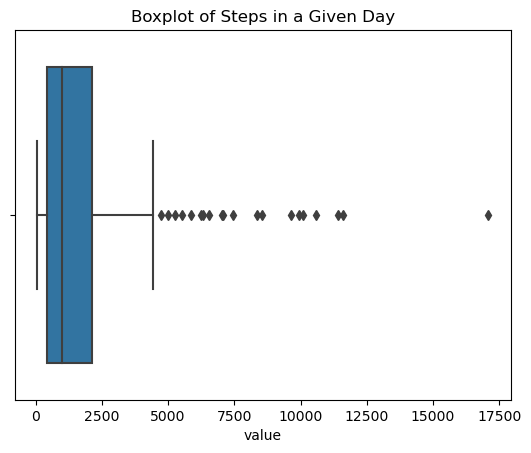

In [26]:
sns.boxplot(data=steps_pred, x=steps_pred["value"])
plt.title("Boxplot of Steps in a Given Day")

In [27]:
steps_pred[(steps_pred['value'] > 10000)]

,DATE,value,TAVG,TMAX,TMIN,month,day,day_of_week
54,2023-02-24,17089,25,32.0,15.0,2,24,4
110,2023-04-21,10568,63,88.0,50.0,4,21,4
112,2023-04-23,10097,50,56.0,43.0,4,23,6
167,2023-06-17,11419,62,73.0,56.0,6,17,5
227,2023-08-25,11617,72,79.0,68.0,8,25,4


In [28]:
# Filtering data further to be any days below 5000 steps
steps_pred = steps_pred[(steps_pred['value'] < 5000)].copy()

In [29]:
# Use linear regression to predict steps based on the avg temperature
X_lr = steps_pred[['TAVG']]
y_lr = steps_pred[['value']]

lr = LinearRegression()
lr.fit(X_lr, y_lr)

LinearRegression()

In [30]:
steps_pred['steps_predicted'] = lr.predict(steps_pred[['TAVG']])

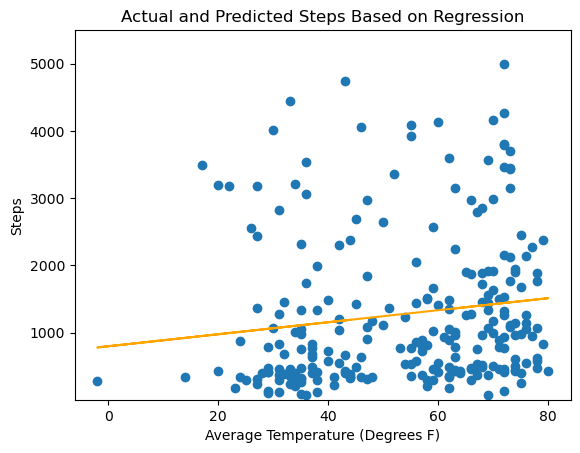

In [31]:
# Plot the actual steps with predicted regression
plt.scatter(steps_pred['TAVG'], steps_pred['value'])
plt.plot(steps_pred['TAVG'], steps_pred['steps_predicted'], color='orange')
plt.xlabel('Average Temperature (Degrees F)')
plt.ylabel('Steps')
plt.ylim(1,5500)
plt.title('Actual and Predicted Steps Based on Regression')
plt.show()

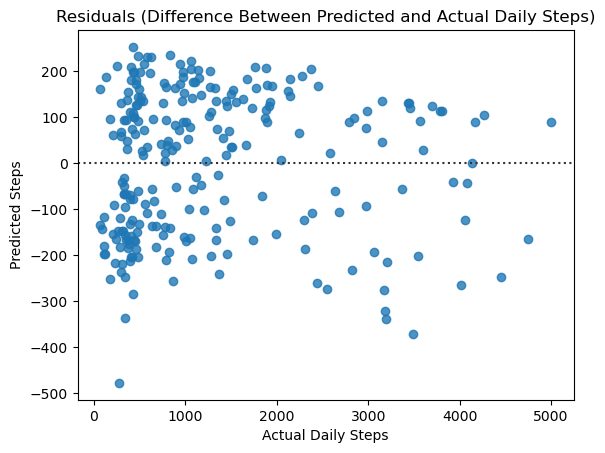

In [32]:
# Plot residuals from the linear regression model
sns.residplot(x = steps_pred['value'], y = steps_pred['steps_predicted'], data = steps_pred)
plt.title('Residuals (Difference Between Predicted and Actual Daily Steps)')
plt.xlabel('Actual Daily Steps')
plt.ylabel('Predicted Steps')
plt.show()

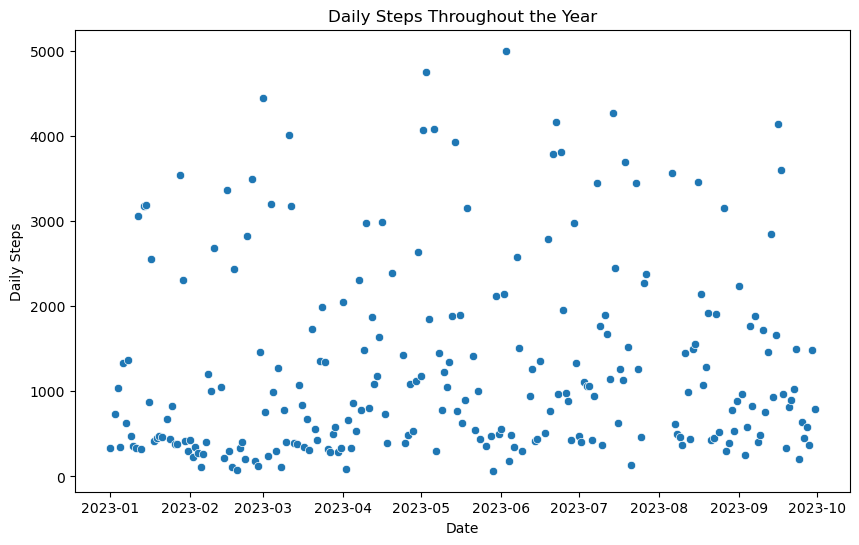

In [33]:
# Plot the daily steps with dates
plt1 = plt.figure(figsize=(10, 6))
sns.scatterplot(x = steps_pred['DATE'], y = steps_pred['value'])
plt.xlabel('Date')
plt.ylabel('Daily Steps')
plt.title('Daily Steps Throughout the Year')
plt.show()